In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('co2_mm_mlo(1).csv')

# Preprocess the data
data['Date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))
data.set_index('Date', inplace=True)
print(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

def moving_average(data, k):
    return data['average'].rolling(window=k).mean().dropna()

def ARMA_model(train_data, test_data, p, q):
    history = [x for x in train_data['average']]
    predictions = []
    for t in range(len(test_data)):
        model = ARIMA(history, order=(p,0,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data['average'][t]
        history.append(obs)
    return predictions

def MLP_model(train_data, test_data, k):
    X_train, y_train = [], []
    for i in range(len(train_data)-k):
        X_train.append(train_data.iloc[i:i+k]['average'].values)
        y_train.append(train_data.iloc[i+k]['average'])
    X_test = [test_data.iloc[i:i+k]['average'].values for i in range(len(test_data)-k)]
    y_test = test_data.iloc[k:]['average'].values

    model = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Example usage:
k = 3
ma_predictions = moving_average(test_data, k)

p = 2
q = 1
arma_predictions = ARMA_model(train_data, test_data, p, q)

mlp_predictions = MLP_model(train_data, test_data, k)

print("Length of ma_predictions:", len(ma_predictions))
print("Length of arma_predictions:", len(arma_predictions))
print("Length of mlp_predictions:", len(mlp_predictions))
print("Length of actual values:", len(test_data['average'][k:]))


            year  month  decimal date  average  deseasonalized  ndays  sdev  \
Date                                                                          
1958-03-01  1958      3     1958.2027   315.70          314.43     -1 -9.99   
1958-04-01  1958      4     1958.2877   317.45          315.16     -1 -9.99   
1958-05-01  1958      5     1958.3699   317.51          314.71     -1 -9.99   
1958-06-01  1958      6     1958.4548   317.24          315.14     -1 -9.99   
1958-07-01  1958      7     1958.5370   315.86          315.18     -1 -9.99   
...          ...    ...           ...      ...             ...    ...   ...   
2023-10-01  2023     10     2023.7917   418.82          422.12     27  0.47   
2023-11-01  2023     11     2023.8750   420.46          422.46     21  0.91   
2023-12-01  2023     12     2023.9583   421.86          422.58     20  0.68   
2024-01-01  2024      1     2024.0417   422.80          422.45     27  0.73   
2024-02-01  2024      2     2024.1250   424.55      

In [ ]:
# Comparing the results
min_length = min(len(ma_predictions), len(arma_predictions), len(mlp_predictions))
ma_mse = mean_squared_error(test_data['average'][:min_length], ma_predictions[:min_length])
arma_mse = mean_squared_error(test_data['average'][:min_length], arma_predictions[:min_length])
mlp_mse = mean_squared_error(test_data['average'][:min_length], mlp_predictions[:min_length])

print("MA Model MSE:", ma_mse)
print("ARMA Model MSE:", arma_mse)
print("MLP Model MSE:", mlp_mse)


MA Model MSE: 1.5539545584045573
ARMA Model MSE: 0.8953851948901151
MLP Model MSE: 1.4058942635597997


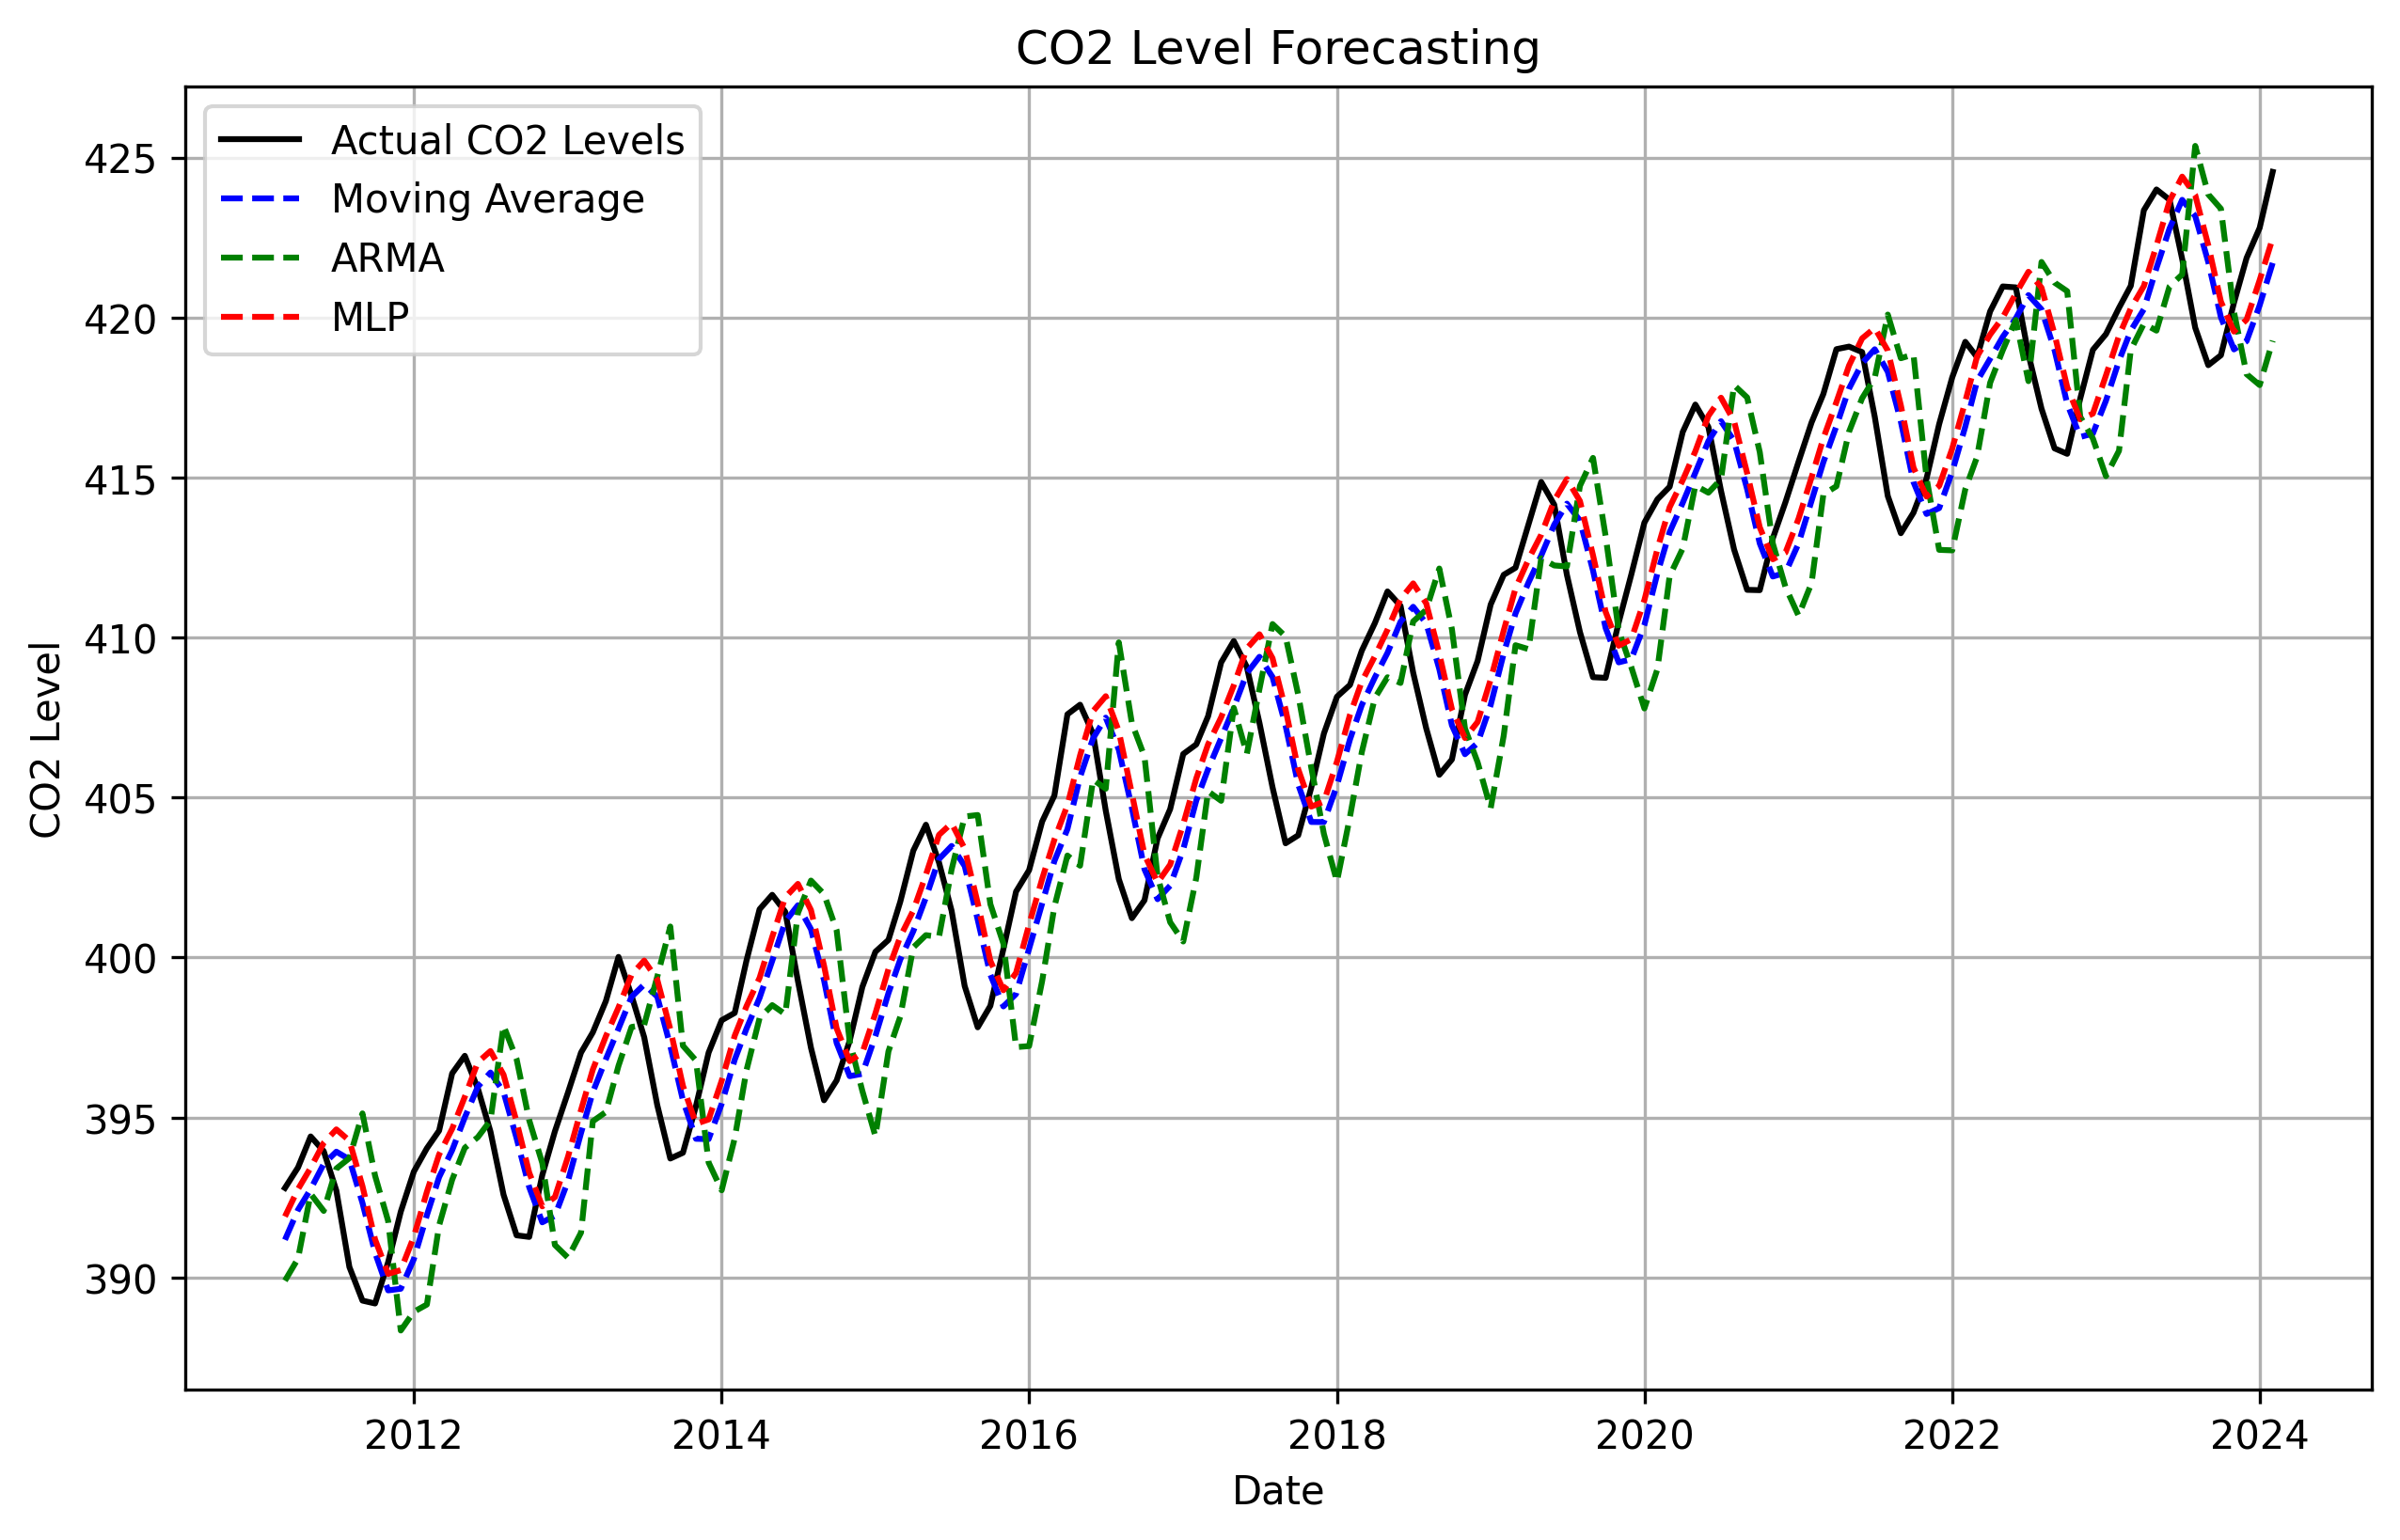

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[K:], test_data['average'][K:], label='Actual CO2 Levels', color='black')
plt.plot(test_data.index[K:], ma_predictions[:len(test_data) - K], label='Moving Average', linestyle='--', color='blue')
plt.plot(test_data.index[K:], arma_predictions[:len(test_data) - K], label='ARMA', linestyle='--', color='green')
plt.plot(test_data.index[K:], mlp_predictions[:len(test_data) - K], label='MLP', linestyle='--', color='red')

plt.title('CO2 Level Forecasting')
plt.xlabel('Date')
plt.ylabel('CO2 Level')
plt.legend()
plt.grid(True)
plt.show()
